# Symmetrical components

*A tutorial on how to work with power system symmetrical components and phasors in Python.*

Electrical power systems are often composed of three phases, i.e.: three sinusoidal waves delayed by 1/3 of a cycle between each other. This allows for the a constant power delivery with alternating voltage and current, optimized material cost and smooth current to the load. Those three phases are often designated A, B and C.

Handling voltages and currents for a 3-phase unbalanced signal is challenging; for this reason, Fortescue's theorem (symmetrical components) is often used to decompose the 3-phase unbalanced signal into 3 balanced signals: the positive (direct) sequence, negative (inverse) sequence and zero (homopolar) sequence.

This article shows how to present and handle such signals in Python. Although Python natively supports complex numbers and [NumPy](https://numpy.org/) supports matrices and vectors, calculating symmetrical components from phase signals and working with phasors is not straightforward. I hope the information below will be helpful to some.

The article is not intended to be a guide on the theory of symmetrical components outside of their manipulation in Python. There are plenty of guides available on this subject, for example this one: [https://www.studyforfe.com/blog/symmetrical-components/](https://www.studyforfe.com/blog/symmetrical-components/)

## Requirements

This note was made in a [jupyter](https://jupyter.org/) notebook (available in the [blog's repo](https://github.com/miek770/blog/blob/main/raws/2023-07-13.ipynb)) in [VS Code](https://code.visualstudio.com/), but the program itself can be run in a simple python script (a `.py` file).

Assuming you're on Windows with the Python launcher installed (comes with recent versions of Python), the [NumPy](https://pypi.org/project/numpy/), [matplotlib](https://pypi.org/project/matplotlib/) and [energy-tools](https://pypi.org/project/energy-tools/) packages have to be installed manually with:

`py -m pip install numpy matplotlib energy_tools`

On Linux, it probably depends on the system, but on mine I have to run `python3 -m pip install ...` instead of the above.

## Time domain

### Balanced 3-phase signal

This section shows how to plot a balanced, 3-phase signal. It's not particularly useful in itself but it's interesting to show the total power output in this configuration (it's linear).

First, the more-than-popular [NumPy](https://numpy.org/) library is required, in addition to [Matplotlib](https://matplotlib.org/) for visualization:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

A few basic parameters are set:

In [2]:
freq_hz = 60    # Frequency (Hz)
samples = 1000  # Number of samples (unitless)
current = 100   # RMS current (A)

This current value, however, is the ***rms*** current (root mean square), which is the value of direct current (DC) that would dissipate the same heat through a resistor. To plot waveforms, the current (and later the voltage) must be multiplied by the square root of 2 to show the correct amplitude.

In [3]:
i_peak = current * 2**0.5  # Peak current (A)

`numpy.linspace` is really conventient to create time periods over the desired range, with the desired number of samples:

In [4]:
# Time domain
t = np.linspace(0, 1 / freq_hz, samples)

`numpy.sin` expects radians, so the frequency needs to be converted accordingly:

In [5]:
# Currents for phases A, B and C
Ia = i_peak * np.sin(2 * np.pi * freq_hz * t)
Ib = i_peak * np.sin(2 * np.pi * freq_hz * t + (2 * np.pi / 3))
Ic = i_peak * np.sin(2 * np.pi * freq_hz * t + (4 * np.pi / 3))

> To avoid undesired text output from matplotlib in jupyter notebooks, the code paragraph should end with `plt.show()`. Putting a semicolon ";" at the end of the last line generally works as well, but it doesn't always work for me, contrary to this solution. See [here](https://stackoverflow.com/questions/45516770/how-do-i-omit-matplotlib-printed-output-in-python-jupyter-notebook) for more details.

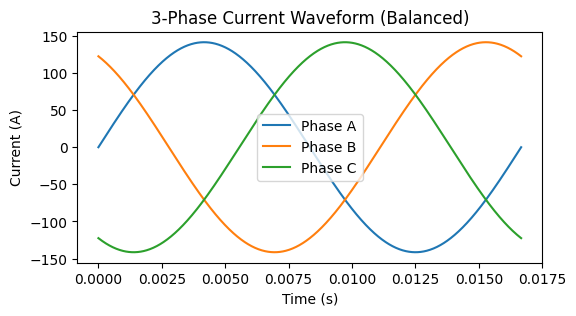

In [6]:
plt.figure(figsize=(6, 3))

plt.plot(t, Ia, label="Phase A")
plt.plot(t, Ib, label="Phase B")
plt.plot(t, Ic, label="Phase C")

plt.xlabel("Time (s)")
plt.ylabel("Current (A)")
plt.title(f"3-Phase Current Waveform (Balanced)")
plt.legend()

plt.show()

It's often more convenient to plot the time as fractions of a cycle; to achieve this, variable `t` can simply be replaced with the following:

In [7]:
t_cycle = t * freq_hz

In [8]:
%%capture
plt.clf()

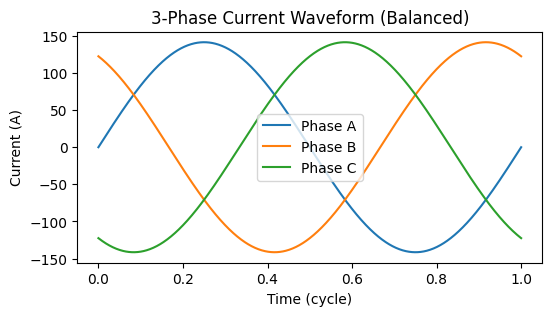

In [9]:
plt.figure(figsize=(6, 3))

plt.plot(t_cycle, Ia, label="Phase A")
plt.plot(t_cycle, Ib, label="Phase B")
plt.plot(t_cycle, Ic, label="Phase C")

plt.xlabel("Time (cycle)")
plt.ylabel("Current (A)")
plt.title(f"3-Phase Current Waveform (Balanced)")
plt.legend()

plt.show()

As I mentioned above, a 3-phase system allows us to transfer *constant power* with alternative current. For a 3-phase circuit, the power equals:

Where:

* S = Power (VA)
* V = Phase-to-phase voltage (V)
* I = Current (A)

> I'm intentionnal ignoring the nuance between apparent, reactive and active / real power for now; it's not required for this example.

We can thus calulate the power in the circuit assuming a phase-to-phase voltage. Using 280V, a common voltage in industrial distribution...

In [10]:
voltage = 208  # Volts (phase-to-phase)

> The phase-to-phase voltage (rms) has to be converted to phase-to-ground (peak), by multiplying it by the square root or 2 and dividing it by the square root of 3:

In [11]:
vln_peak = voltage * 2**0.5 / 3**0.5

In [12]:
# Voltages for phases A, B and C
Va = vln_peak * np.sin(2 * np.pi * freq_hz * t)
Vb = vln_peak * np.sin(2 * np.pi * freq_hz * t + (2 * np.pi / 3))
Vc = vln_peak * np.sin(2 * np.pi * freq_hz * t + (4 * np.pi / 3))

Finally, the power is 

In [13]:
# Power for phases A, B and C (kVA)
Sa = Va * Ia / 1e3
Sb = Vb * Ib / 1e3
Sc = Vc * Ic / 1e3

### Single phase power

Plotting for a single phase shows how the power is *not* constant. On a motor or generator, this means vibration and it's not desirable.

> I like to clear the figure - using `plt.clf()` - between each plot to ensure I'm not carrying undesired settings from one figure to the next. The problem is that a semicolon at the end isn't enough to supress its annoying output, so the jupyter magic word `%%capture` is used instead.

In [14]:
%%capture
plt.clf()

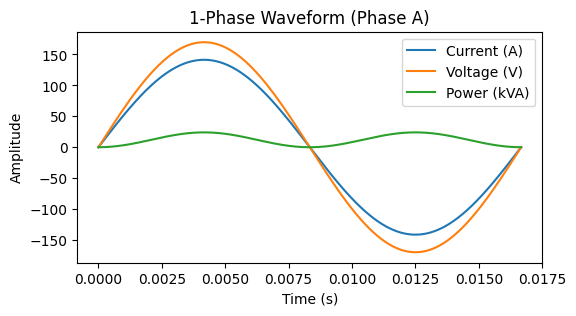

In [15]:
plt.figure(figsize=(6, 3))

plt.plot(t, Ia, label="Current (A)")
plt.plot(t, Va, label="Voltage (V)")
plt.plot(t, Sa, label="Power (kVA)")

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f"1-Phase Waveform (Phase A)")
plt.legend()

plt.show()

### 3-phase power

With the three phases, the total power output (in red in the following figure) is clearly constant and equals:

In [16]:
%%capture
plt.clf()

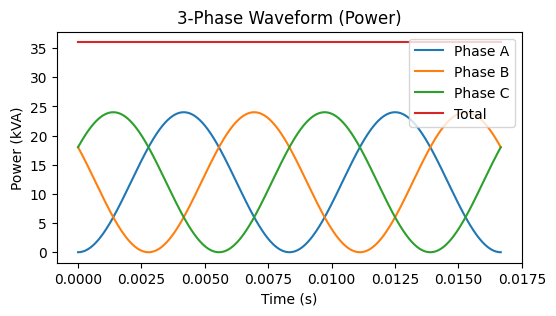

In [17]:
plt.figure(figsize=(6, 3))

plt.plot(t, Sa, label="Phase A")
plt.plot(t, Sb, label="Phase B")
plt.plot(t, Sc, label="Phase C")
plt.plot(t, Sa + Sb + Sc, label="Total")

plt.xlabel("Time (s)")
plt.ylabel("Power (kVA)")
plt.title(f"3-Phase Waveform (Power)")
plt.legend()

plt.show()

## Phasors

### Balanced 3-phase signal

Electrical voltage, current and power are also often presented as phasors, which are basically vectors presented on a polar plot. The angle on the plot represents the phase, and the length of the vector the amplitude.

I made a small library, [energy-tools](https://gitlab.com/miek770/energy_tools) which includes a `Phasor` class that makes it easier to work with those, as well as an `EleComplex` class which improves the built in `complex` type for electrical systems. The `Phasor` takes up to 2 arguments: either a complex number, or the amplitude and the phase shift in degrees (optional, defaults to 0).

We'll work with RMS amplitudes for the phasors. Because the currents are balanced in this example, we simply need to shift phase A by 120 degrees and 240 degrees to obtain phases B and C:

In [18]:
from energy_tools.phasor import Phasor

In [19]:
a = Phasor(1, -120)

In [20]:
Ia = Phasor(current)
Ib = Ia / a
Ic = Ia / a**2

In [21]:
%%capture
plt.clf()

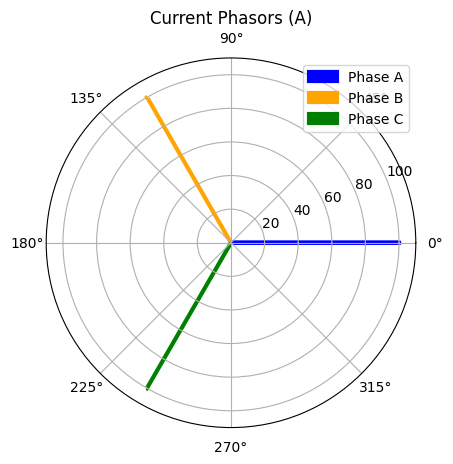

In [22]:
ax = plt.subplot(1, 1, 1, polar=True)

plt.arrow(0, 0, Ia.pha * np.pi / 180, Ia.amp,
          lw=3, color="blue", label="Phase A")
plt.arrow(0, 0, Ib.pha * np.pi / 180, Ib.amp,
          lw=3, color="orange", label="Phase B")
plt.arrow(0, 0, Ic.pha * np.pi / 180, Ic.amp,
          lw=3, color="green", label="Phase C")

plt.title("Current Phasors (A)")
ax.set_rlim(0, Ia.amp * 1.1)
plt.legend()

plt.show()

In a balanced 3-phase signal such as this one, there is no need to decompose the signal into symmetrical components (the positive sequence is equal to the 3 phases, and the negative and zero sequences are null).

### Symmetrical components

The mathematical relationship between phase signals and symmetrical components can be defined by the following equation (see [Tutorial on symmetrical components - Part 1: Examples by SEL](https://cdn.selinc.com/assets/Literature/Publications/White%20Papers/LWP0010-01_TutorialSymmetrical-Pt1_AR_20130422.pdf) and its references for great sources of information on this subject):

%%latex
$\begin{bmatrix}V_a\\V_b\\V_c\end{bmatrix} = \begin{bmatrix}1 & 1 & 1\\a² & a & 1\\a & a² & 1\end{bmatrix}\begin{bmatrix}V_{a1}\\V_{a2}\\V_{a0}\end{bmatrix}$

or:

%%latex
$V_p = A V_s$

To calculate the symmetrical components from the phase signals, matrix `A` must be inversed:

%%latex
$\begin{bmatrix}V_{a1}\\V_{a2}\\V_{a0}\end{bmatrix} = \frac{1}{3}\begin{bmatrix}1 & a & a²\\1 & a² & a\\1 & 1 & 1\end{bmatrix}\begin{bmatrix}V_a\\V_b\\V_c\end{bmatrix}$

or:

%%latex
$V_s = A^{-1} V_p$

In Python, the `A` matrix can be defined as:

In [23]:
A = np.matrix([
    [1,    1,      1],
    [a**2, a,      1],
    [a,    a ** 2, 1],
])

Although NumPy provides `numpy.linalg.inv`, a function used to compute the inverse of a matrix (see [doc](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html)), the function does not work with the custom `Phasor` data type. However, the inverse of `A` is already well known and documented so it can simply be defined manually:

In [24]:
A_inv = (1 / 3) * np.matrix([
    [1, a,    a**2],
    [1, a**2, a],
    [1, 1,    1],
])

The matrices above present voltages, but this conversion applies to other quantities such as currents.

#### Balanced 3-phase signal

This example demonstrates that only the positive (direct) sequence is present in a balanced 3-phase signal.

In [25]:
Ip_bal = np.matrix([[Ia], [Ib], [Ic]])

In [26]:
print(f"Ip (balanced):\n\n{Ip_bal}")

Ip (balanced):

[[100.0 @ 0.0°]
 [100.0 @ 120.0°]
 [100.0 @ 240.0°]]


<br />

In [27]:
Is_bal = A_inv * Ip_bal

In [28]:
Is1_bal, Is2_bal, Is0_bal = (Is_bal[x].item() for x in range(3))

In [29]:
print(f"Positive sequence: {Is1_bal}")
print(f"Negative sequence: {Is2_bal}")
print(f"Zero sequence:     {Is0_bal}")

Positive sequence: 100.0 @ 0.0°
Negative sequence: 0.0 @ 78.69°
Zero sequence:     0.0 @ 123.69°


<br />

As expected, the negative and zero sequences are null because the 3 phases are perfectly balanced.

> The positive sequence of a 3-phase signal is always composed of 3 symmetrical phase components, phase shifted by 120 degrees. The negative sequence is also composed of 3 symmetrical phase components, phase shifted by 120 degrees *in the opposite direction* compared to the positive sequence. The zero sequence's 3 phase components are always equal and in phase.

A function would be convenient to plot symmetrical components:

In [30]:
def plot_symmetrical_components(Is1: Phasor, Is2: Phasor, Is0: Phasor):
    fig, (ax1, ax2, ax3) = plt.subplots(
        3, 1, figsize=(12, 12),
        subplot_kw={'projection': 'polar'},
    )

    scale = 1.1 * max([
        Is1.amp,
        Is2.amp,
        Is0.amp,
    ])

    if Is1.amp > 0:
        ax1.arrow(0, 0, (Is1.pha * np.pi / 180), Is1.amp,
                  lw=3, color="blue", label="Phase A")
        ax1.arrow(0, 0, (Is1.pha * np.pi / 180) + 2 * np.pi / 3, Is1.amp,
                  lw=3, color="orange", label="Phase B")
        ax1.arrow(0, 0, (Is1.pha * np.pi / 180) - 2 * np.pi / 3, Is1.amp,
                  lw=3, color="green", label="Phase C")
    ax1.set_title('Positive sequence')
    ax1.set_rlim(0, scale)
    ax1.legend()

    if Is2.amp > 0:
        ax2.arrow(
            0, 0, (Is2.pha * np.pi / 180), Is2.amp, lw=3,
            color="blue", label="Phase A",
        )
        ax2.arrow(0, 0, (Is2.pha * np.pi / 180) - 2 * np.pi / 3, Is2.amp,
                  lw=3, color="orange", label="Phase B")
        ax2.arrow(0, 0, (Is2.pha * np.pi / 180) + 2 * np.pi / 3, Is2.amp,
                  lw=3, color="green", label="Phase C")
    ax2.set_title('Negative sequence')
    ax2.set_rlim(0, scale)
    ax2.legend()

    if Is0.amp > 0:
        ax3.arrow(0, 0, Is0.pha * np.pi / 180, Is0.amp, lw=3)
    ax3.set_title('Zero sequence')
    ax3.set_rlim(0, scale)

    # Adjust the layout and spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()

In [31]:
%%capture
plt.clf()

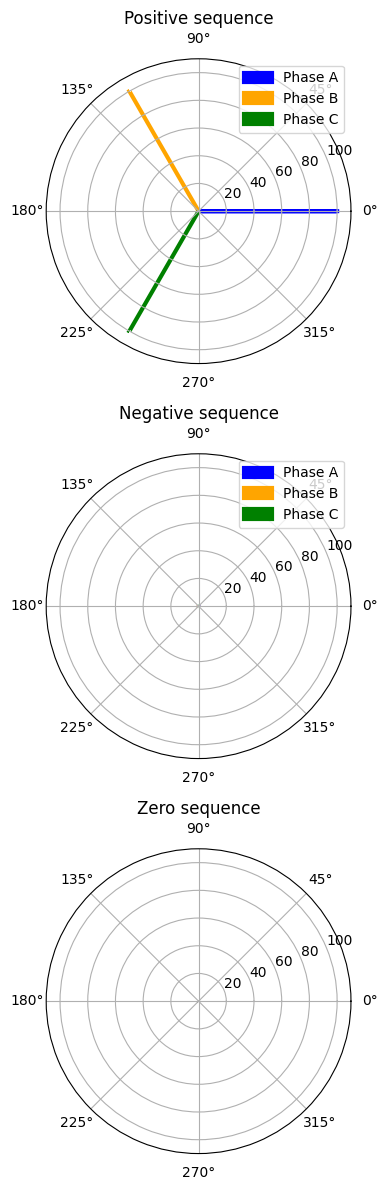

In [32]:
plot_symmetrical_components(Is1_bal, Is2_bal, Is0_bal)

#### Unbalanced 3-phase signal

This example shows each sequence for an unbalanced 3-phase signal:

In [33]:
# Currents for phases A, B and C,
# based on the ones we defined earlier
Ia_unb = Ia
Ib_unb = Ib * 1.5
Ic_unb = Ic * 0.7

In [34]:
Ip_unb = np.matrix([[Ia_unb], [Ib_unb], [Ic_unb]])

Applying the same conversion as before...

In [35]:
Is_unb = A_inv * Ip_unb

...and extracting positive, negative and zero sequence components:

In [36]:
Is1_unb, Is2_unb, Is0_unb = (Is_unb[x].item() for x in range(3))

In [37]:
%%capture
plt.clf()

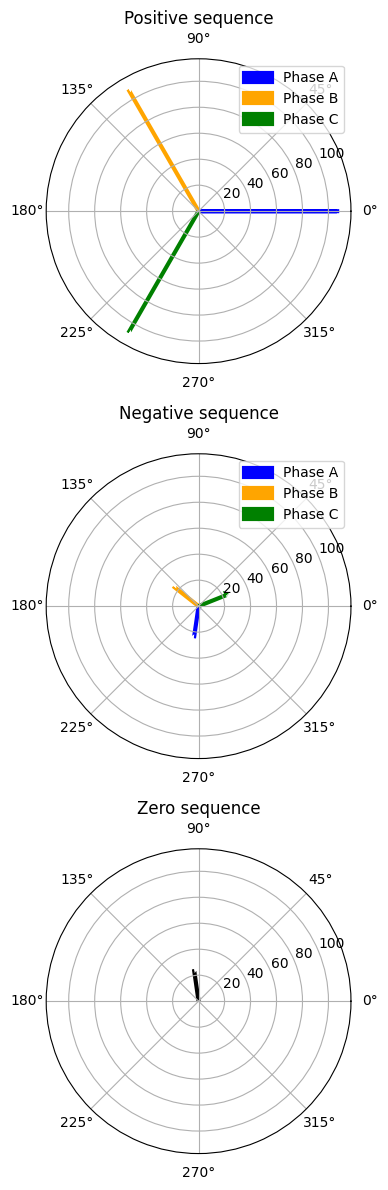

In [38]:
plot_symmetrical_components(Is1_unb, Is2_unb, Is0_unb)

As shown in the previous figure, the phase rotation (the order of colors) in the negative sequence is the opposite of the positive sequence (hence its other name - inverse sequence).

### Phasor operations

The `energy_tools.phasor.Phasor` class provides several convenient methods, attributes and operations. Here are a few examples:

In [39]:
x = Phasor(10, 0)

In [40]:
print(f"Phasor x has an amplitude of {x.amp}, and a \
phase of {x.pha} degrees.")

Phasor x has an amplitude of 10.0, and a phase of 0.0 degrees.


<br />

In [41]:
print(f"Its real component is {x.real}; its \
complex component is {x.imag}.")

Its real component is 10.0; its complex component is 0.0.


<br />

In [42]:
y = Phasor(5, 120)
z = Phasor(12, 252)

In [43]:
print(f"Phasor x multiplied by phasor y equals {x * y}")

Phasor x multiplied by phasor y equals 50.0 @ 120.0°


<br />

(The amplitudes are multiplied; the phases are added.)

In [44]:
print(f"Phasor y divided by phasor z equals {y / z}")

Phasor y divided by phasor z equals 0.417 @ 228.0°


<br />

(The amplitudes are divided; the phase of the demoninatoris substracted from the numerator's.)

In [45]:
print(f"The inverse of phase y equals {1 / y}")

The inverse of phase y equals 0.2 @ 300.0°


<br />

(Its new amplitude is equal to (1 / amplitude); its phase is shifted by 180 degrees.)

> The `energy_tools` library was developped as a hobby; it was not rigourously tested and should not be used in real life applications *without proper validation*. Comments and feedback are more than welcome on [the project's repo](https://gitlab.com/miek770/energy_tools/-/issues).

## Conclusion

Python is great for handling power system signals, phasors and symmetrical components with the right tools. The `Phasor` class is especially useful to handle this key data type that is not well covered in the core libraries and NumPy.

I did not cover complex numbers (or `energy_tools.complex`'s `EleComplex` class) but anyone who has worked with those in Excel knows that there must be better solutions; Python definitely is one. The `EleComplex` class essentially adds `phase` and `pf` (power factor) methods, for convenience.